scope_312  SNR: 16.23
scope_313  SNR: 17.49
scope_314  SNR: 17.10
scope_315  SNR: 9.11
scope_316  SNR: 18.03
scope_317  SNR: 12.00
scope_318  SNR: 16.30
scope_319  SNR: 17.59
scope_320  SNR: 16.44
scope_321  SNR: 20.33
scope_322  SNR: 19.05
scope_323  SNR: 8.13
scope_324  SNR: 16.30
scope_325  SNR: 16.10
scope_326  SNR: 11.46
scope_327  SNR: 18.08
scope_328  SNR: 16.63
scope_329  SNR: 21.02
scope_330  SNR: 9.57
scope_331  SNR: 18.64


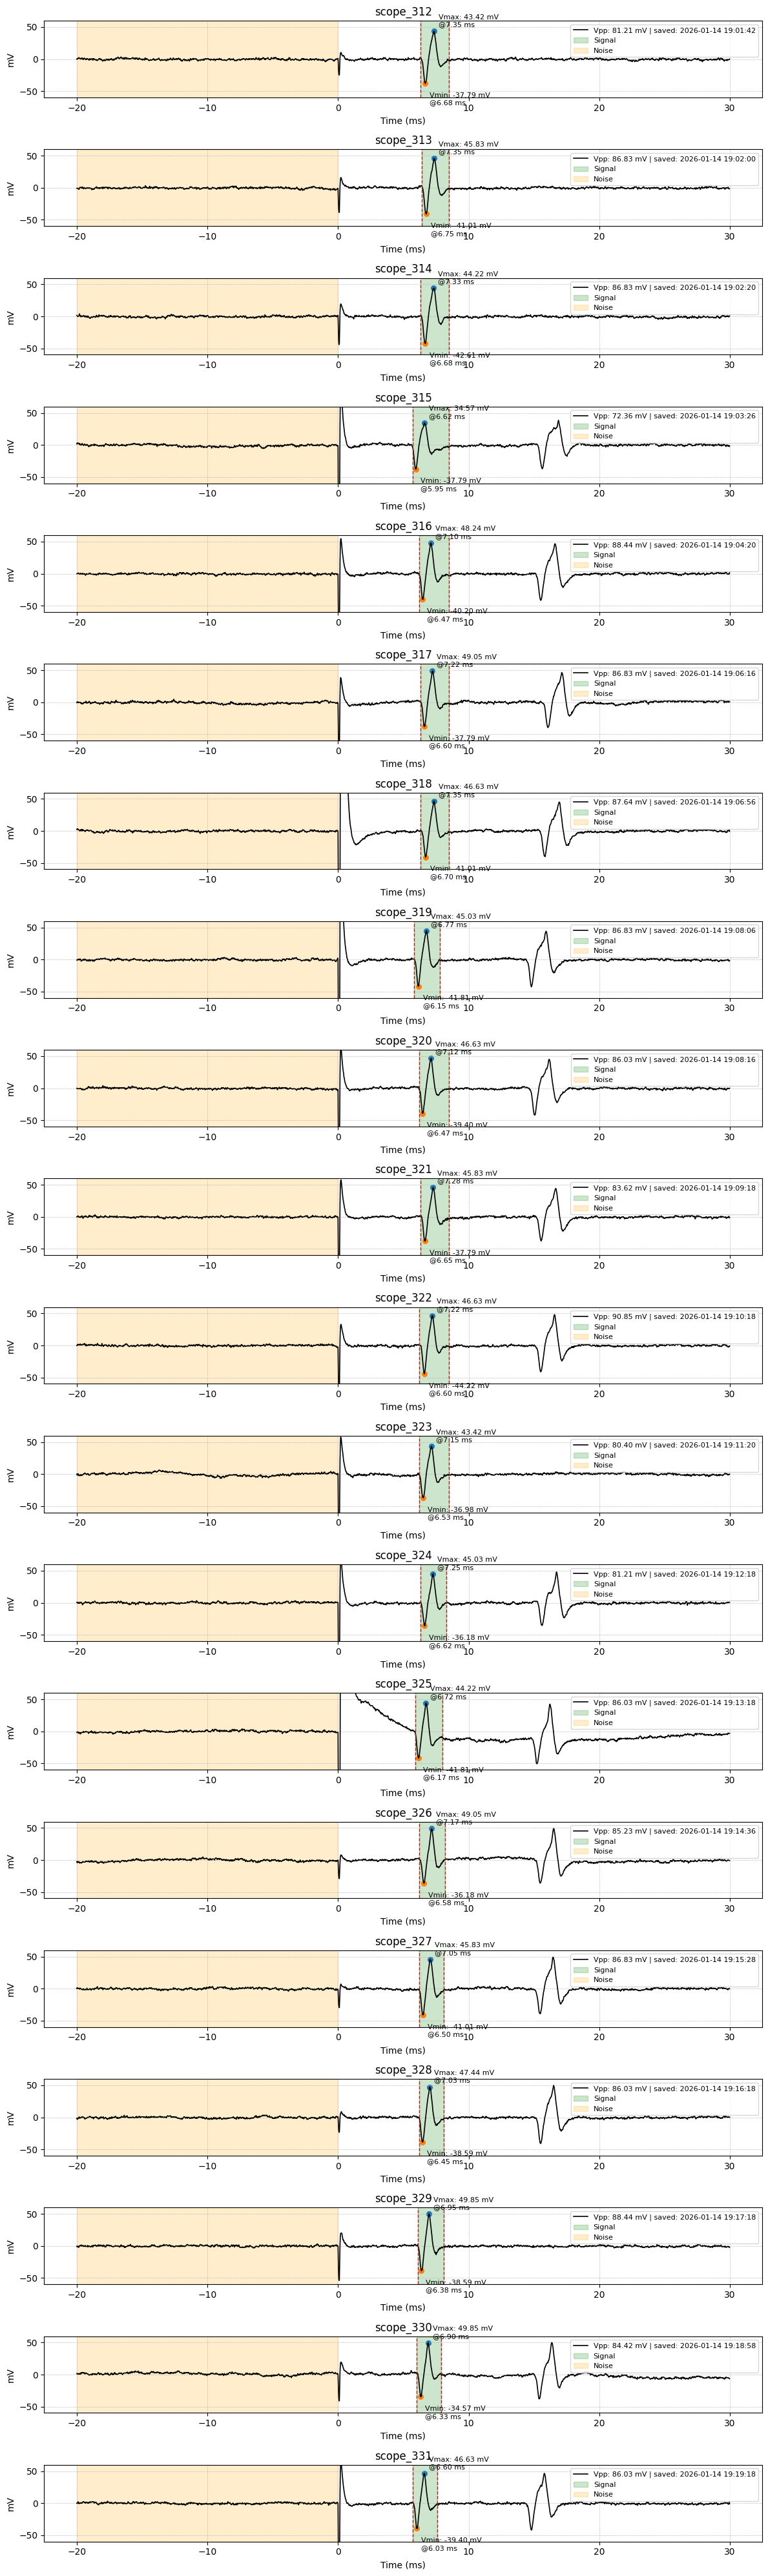

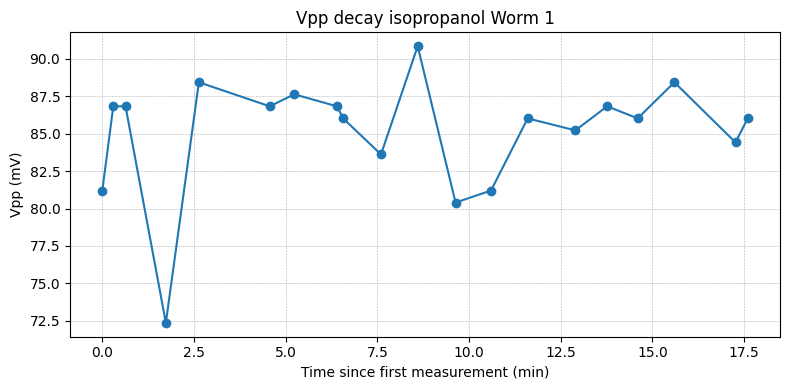

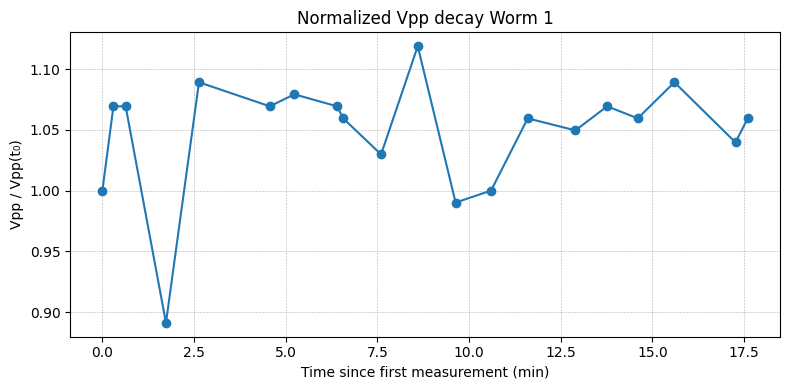


Average SNR (linear): 15.78
Average SNR (dB): 23.96 dB
Average Vpp: 85.11 mV


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

folder = "Worm 1"
scope_start = 312
num_files = 20

time_windows = [
    (6.3, 8.5), #12
    (6.4, 8.5), #13
    (6.3, 8.5), #14
    (5.7, 8.5), #15
    (6.2, 8.5), #16
    (6.3, 8.5), #17
    (6.3, 8.5), #18
    (5.8, 7.8), #19
    (6.2, 8.5), #20
    (6.3, 8.5), #21
    (6.2, 8.5), #22
    (6.2, 8.5), #23
    (6.3, 8.3), #24
    (5.9, 8),   #25
    (6.2, 8.2), #26
    (6.2, 8.1), #27
    (6.2, 8.1), #28
    (6.1, 8.1), #29
    (6, 7.9),   #30
    (5.7, 7.6), #31
]

vpp_values = []
timestamps = []
snr_values = []

fig1, axes = plt.subplots(num_files, 1, figsize=(12, num_files * 2), sharex=False)

for i in range(num_files):
    scope = scope_start + i
    ax = axes[i]
    file_path = os.path.join(folder, f"scope_{scope}.csv")
    t_start, t_end = time_windows[i]

    df = pd.read_csv(file_path)
    df = df.drop(index=0).reset_index(drop=True)
    df = df.apply(pd.to_numeric)

    t_ms = df["x-axis"].values * 1e3
    ch2_mV = df["2"].values * 1e3

    mtime = os.path.getmtime(file_path)
    ts = datetime.fromtimestamp(mtime, tz=ZoneInfo("Europe/Amsterdam"))
    timestamps.append(ts)
    timestamp_str = ts.strftime("%Y-%m-%d %H:%M:%S")

    signal_mask = (t_ms >= t_start) & (t_ms <= t_end)
    noise_mask = (t_ms >= -20) & (t_ms <= -0.01)

    signal_vals = ch2_mV[signal_mask]
    vmax = np.max(signal_vals)
    vmin = np.min(signal_vals)
    vpp = vmax - vmin
    vpp_values.append(vpp)

    seg_indices = np.where(signal_mask)[0]
    idx_vmax = seg_indices[np.argmax(ch2_mV[seg_indices])]
    idx_vmin = seg_indices[np.argmin(ch2_mV[seg_indices])]
    vmax_t = t_ms[idx_vmax]
    vmin_t = t_ms[idx_vmin]

    signal_vrms = np.sqrt(np.mean(ch2_mV[signal_mask] ** 2))
    noise_vrms = np.sqrt(np.mean(ch2_mV[noise_mask] ** 2))
    snr = signal_vrms / noise_vrms
    snr_values.append(snr)

    print(f"scope_{scope}  SNR: {snr:.2f}")

    ax.plot(
        t_ms,
        ch2_mV,
        linewidth=1.2,
        color="black",
        label=f"Vpp: {vpp:.2f} mV | saved: {timestamp_str}",
    )

    ax.axvline(t_start, color="red", linestyle="--", linewidth=1)
    ax.axvline(t_end, color="red", linestyle="--", linewidth=1)

    ax.fill_between(t_ms, -60, 60, where=signal_mask, color="green", alpha=0.2, label="Signal")
    ax.fill_between(t_ms, -60, 60, where=noise_mask, color="orange", alpha=0.2, label="Noise")

    ax.scatter(vmax_t, vmax, s=30)
    ax.scatter(vmin_t, vmin, s=30)

    ax.annotate(
        f"Vmax: {vmax:.2f} mV\n@{vmax_t:.2f} ms",
        (vmax_t, vmax),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )
    ax.annotate(
        f"Vmin: {vmin:.2f} mV\n@{vmin_t:.2f} ms",
        (vmin_t, vmin),
        xytext=(5, -24),
        textcoords="offset points",
        fontsize=8,
    )

    ax.set_ylim(-60, 60)
    ax.set_ylabel("mV")
    ax.set_xlabel("Time (ms)")
    ax.set_title(f"scope_{scope}")
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)
    ax.legend(loc="upper right", fontsize=8)

fig1.tight_layout()
plt.show()

pairs = sorted(zip(timestamps, vpp_values), key=lambda x: x[0])
t0 = pairs[0][0]

time_min = np.array([(ts - t0).total_seconds() / 60.0 for ts, _ in pairs])
vpp_arr = np.array([vpp for _, vpp in pairs])

plt.figure(figsize=(8, 4))
plt.plot(time_min, vpp_arr, "o-")
plt.xlabel("Time since first measurement (min)")
plt.ylabel("Vpp (mV)")
plt.title(f"Vpp decay isopropanol {folder}")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

vpp_norm = vpp_arr / vpp_arr[0]

plt.figure(figsize=(8, 4))
plt.plot(time_min, vpp_norm, "o-")
plt.xlabel("Time since first measurement (min)")
plt.ylabel("Vpp / Vpp(t₀)")
plt.title(f"Normalized Vpp decay {folder}")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

snr_mean = np.mean(snr_values)
snr_mean_db = 20 * np.log10(snr_mean)
print(f"\nAverage SNR (linear): {snr_mean:.2f}")
print(f"Average SNR (dB): {snr_mean_db:.2f} dB")

vpp_mean = np.mean(vpp_values)
print(f"Average Vpp: {vpp_mean:.2f} mV")